In [1]:
import pandas as pd
import os
import git
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
import pymc3 as pm
import theano.tensor as tt

def get_git_root(path):

        git_repo = git.Repo(path, search_parent_directories=True)
        #git_root = git_repo.git.rev_parse("--show-toplevel")
        
        return git_repo.working_dir

In [2]:
top_level_git_dir = get_git_root(os.getcwd())
raw_data_dir = os.path.join(top_level_git_dir, "data", "raw")

train_csv_path = os.path.join(raw_data_dir, "train_values.csv")
test_csv_path = os.path.join(raw_data_dir, "test_values.csv")
train_labels_csv_path = os.path.join(raw_data_dir, "train_labels.csv")
submission_format_csv_path = os.path.join(raw_data_dir, "submission_format.csv")

train_df = pd.read_csv(train_csv_path, index_col = "row_id")
train_labels_df = pd.read_csv(train_labels_csv_path, index_col = "process_id")
test_df = pd.read_csv(test_csv_path, index_col = "row_id")
submission_format_df = pd.read_csv(submission_format_csv_path, index_col = "process_id")


/Users/greg.bolla/.local/share/virtualenvs/driven-data-rinse-over-run-w5STMFPe/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
def prep_full_df(df):

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    df = df.assign(turbidity_in_liters = \
        np.maximum(0, df.return_flow) * df.return_turbidity)

    df['process_phase'] = df.process_id.astype(str) + "_" + df.phase.astype(str)
    df = df[df.phase != "final_rinse"]
    
    return df

In [4]:
def prep_metadata(df):
    meta_df = df[["process_id", "pipeline"]].drop_duplicates().set_index("process_id")
    meta_df = pd.get_dummies(meta_df)
    
    if 'L12' not in meta_df.columns:
        meta_df['pipeline_L12'] = False
    
    for col in meta_df.columns:
        if "pipeline" in col:
            meta_df[col] = meta_df[col].astype(bool)
            
    meta_df["num_phases"] = df.groupby("process_id")["phase"].apply(lambda x: x.nunique())
    
    return meta_df

In [5]:
ts_cols = [
    'process_id',
    'timestamp',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
    "turbidity_in_liters"
]

def prep_time_series_features(df, columns = None):
    
    if columns is None:
        columns = df.columns
    
    df = df.sort_values(by=["process_id", "timestamp"], ascending=True)
    process_duration_ts = df.groupby('process_id')["timestamp"].max() - df.groupby('process_id')["timestamp"].min() 
    process_duration_ts = process_duration_ts.rename('process_duration')
    process_duration = process_duration_ts.apply(lambda row: row.total_seconds())
    
    ts_df = df[ts_cols].set_index('process_id')
    
    # define fxn before calling in .agg to make col name more descriptive (in place of <lambda>)
    def last_five_mean(x):
        return x.tail(5).mean()
    
    ts_features_agg_df = ts_df.groupby('process_id').agg(['min', 'max', 'mean', 'std', last_five_mean])
    
    ts_features_df = pd.concat([process_duration, ts_features_agg_df], axis = 1)
    return ts_features_df

In [6]:
def prep_dummy_vars(df):
    
    categorical_cols = ["num_phases"]

    for cat_col in categorical_cols:
        dummy_df = pd.get_dummies(df[cat_col], prefix=cat_col, dummy_na = False)
        dummy_df = dummy_df.astype('bool')

        drop_val = df.groupby([cat_col]).size().idxmax()

        drop_col = "{}_{}".format(cat_col, drop_val)
        df = pd.concat([df, dummy_df], axis=1)
        df = df.drop(drop_col, axis=1)    
        df[cat_col] = df[cat_col].astype(object)
    
    return df

In [7]:
def clean_feature_df(df):
    
    new_col_names = []
    for col in df.columns.ravel():
        if isinstance(col, str):
            new_col_names.append(col)
        elif isinstance(col, tuple):
            col_name = "{}_{}".format(col[0], col[1])
            new_col_names.append(col_name)
    df.columns = new_col_names
    
    return df

In [8]:
def create_feature_matrix(df):
    
    prepped_df = prep_full_df(df)
    metadata_df = prep_metadata(prepped_df)
    time_series_df = prep_time_series_features(prepped_df)
    
    dfs_to_concat = [metadata_df, time_series_df]
    
    feature_df = pd.concat(dfs_to_concat, axis=1)
    feature_df = prep_dummy_vars(feature_df)
    
    df_to_return = clean_feature_df(feature_df)

    return df_to_return

In [9]:
train_features_df = create_feature_matrix(train_df)

indices_to_keep = list(set(train_features_df.index).intersection(set(train_labels_df.index)))
# figure out why 16 indices dropped out of train_features_df
train_labels_df = train_labels_df[train_labels_df.index.isin(indices_to_keep)]
train_features_w_response = train_features_df.join(train_labels_df)
train_features_w_response.head()

,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L12,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,...,tank_concentration_acid_last_five_mean,turbidity_in_liters_min,turbidity_in_liters_max,turbidity_in_liters_mean,turbidity_in_liters_std,turbidity_in_liters_last_five_mean,num_phases_1,num_phases_2,num_phases_3,final_rinse_total_turbidity_liter
process_id,,,,,,,,,,,,,,,,,,,,,
20001,False,False,False,False,False,False,True,False,False,False,...,44.653038,818.406942,1.579919e+06,105488.460366,174650.861160,30300.051942,False,False,False,4.318275e+06
20002,False,False,False,False,False,True,False,False,False,False,...,44.229616,499.442792,2.976941e+06,854203.372900,563689.439444,949644.159635,False,True,False,4.375286e+05
20003,False,False,False,False,False,True,False,False,False,False,...,44.716846,152.522484,1.431140e+06,44218.000816,127420.220308,5287.641592,False,False,False,4.271977e+05
20004,False,False,False,False,False,False,False,False,True,False,...,45.226021,0.000000,3.162818e+06,212923.854423,387856.686586,22306.533910,False,False,False,7.197830e+05
20005,False,False,False,False,False,False,False,False,True,False,...,43.952939,0.000000,2.066256e+05,23587.698324,26813.228206,45723.010454,True,False,False,4.133107e+05


In [10]:
response_var = ["final_rinse_total_turbidity_liter"]
pred_df = train_features_w_response.drop(response_var, axis=1)
response_df = train_features_w_response[response_var]

pred_train, pred_test, response_train, response_test = train_test_split(pred_df, response_df, test_size=0.01, random_state=223)



In [11]:
def adj_r2_score(lm, y, y_pred):
    adj_r2 = 1 - float(len(y)-1)/(len(y)-len(lm.coef_)-1)*(1 - metrics.r2_score(y,y_pred))
    return adj_r2

In [12]:
def calc_mape(pred_array, actual_array):
    
    threshold = 290000

    
    mape_array = []
    for pred, actual in zip(pred_array, actual_array.values):
        #print("{} - {}".format(pred[0], type(pred[0])))
        #print("{} - {}".format(actual[0], type(actual[0])))
        mape = (abs(pred - actual) / max(abs(actual), threshold))
        mape_array.append(mape)
        
    return mape_array


count    4.954000e+03
mean     2.138861e+06
std      6.314652e+06
min      2.939606e+03
25%      3.134350e+05
50%      6.986369e+05
75%      1.812085e+06
max      1.473866e+08
Name: final_rinse_total_turbidity_liter, dtype: float64

(array([3.476e+03, 6.800e+02, 3.760e+02, 1.830e+02, 6.600e+01, 2.600e+01,
        2.100e+01, 7.000e+00, 6.000e+00, 9.000e+00, 5.000e+00, 1.000e+01,
        5.000e+00, 6.000e+00, 4.000e+00, 3.000e+00, 6.000e+00, 2.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 3.000e+00, 3.000e+00, 6.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

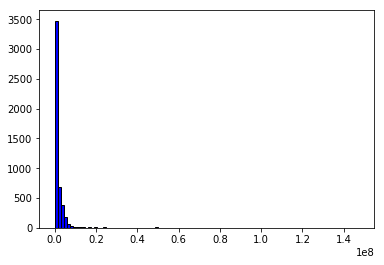

In [14]:
import matplotlib.pyplot as pyplot
pyplot.hist(response_train[response_var], color = 'blue', edgecolor = 'black', bins=100, label=response_var)

In [20]:
# find prior of response variable by simply looking at the mean/sd of response of train
response_var = "final_rinse_total_turbidity_liter"
std = np.std(response_train[response_var])

# will use half normal as the distribution. pareto may also be appropriate
with pm.Model() as turbidity_model: 
    
    x = pm.HalfNormal('x', sd=1, observed=response_train[response_var])

In [19]:
turbidity_model.

[x_log__]